# Course: ICS 574
# Prject: Alchemists Project - EDA
- Date: May 6th 2024
- Project Members
    - ALGHAMDI, BANDAR, ID: 202206560
    - AHMED DHAFER ALQARNI, ID: 201453160
    - WALEED ABDULLAH ALFAIFI, ID: 201640920

The project is divided into 6 parts
1. Preprocessing the data
2. Model Experimentation (this includes model selection, validation, tuning, performance metrics for each model)

    2.1 Decision Tree Classifier Model

    2.2 Decision Tree Regressor Model

    2.3 GBTRegressor Model

    2.4 SGDRegressor Model

# Study Goal

The goal is to predict stocks performance in the energy and materials sectors, considering the stocks historical performance with changes in the prices of Brent oil and gold. This predictive analysis will help in understanding the market's behavior and could be a useful guide for making financial decisions.

# 1. Data Preprocessing

In [86]:
#import needed libraries
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import seaborn as sns
import numpy as np
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# hide WRAN warnings for easier reading
import warnings
warnings.filterwarnings('ignore')

# Create a Spark session
spark = SparkSession.builder.appName("MarketAlchemists").getOrCreate()
spark


In [87]:
# Load the datasets as pandas DataFrames from existing excel files
stocks_df = pd.read_csv("./datasets/Tadawul_stcks.csv")
brent_df = pd.read_csv("./datasets/BrentOilPrices.csv")
gold_df = pd.read_csv("./datasets/Gold_Daily.csv")

# hide warnings for better readability
import warnings
warnings.filterwarnings('ignore')

# Preprocess the stock data as done in the EDA Part
# previously we have seen that the data is not clean and has missing values in Phase 1 of the project
# below code is to clean the data, rename the columns and merge the dataframes
# as done in the EDA Phase 1 part
stocks_specific_df = stocks_df[(stocks_df['sectoer'] == 'Energy') | (stocks_df['sectoer'] == 'Materials')]
stocks_specific_df.rename(columns={'date': 'Date'}, inplace=True)
stocks_specific_df.rename(columns={'close': 'Stock_Price'}, inplace=True)
stocks_specific_df['Date'] = pd.to_datetime(stocks_specific_df['Date'])
brent_df['Date'] = pd.to_datetime(brent_df['Date'])
gold_df['Date'] = pd.to_datetime(gold_df['Date'])
brent_df.rename(columns={'Price': 'Brent_Price'}, inplace=True)
gold_df.rename(columns={'Price': 'Gold_Price'}, inplace=True)
stocks_specific_df.rename(columns={'sectoer': 'Sector'}, inplace=True)
brent_df = brent_df[['Date', 'Brent_Price']]
gold_df = gold_df[['Date', 'Gold_Price']]
stocks_specific_df.fillna(method='ffill', inplace=True)
stocks_brent_df = pd.merge(stocks_specific_df, brent_df, on='Date', how='inner')
stocks_brent_gold_df = pd.merge(stocks_brent_df, gold_df, on='Date', how='inner')

# define a function that does all the above data preprocessing steps so we can use it before we try different models with original data
def preprocess_data(stocks_df, brent_df, gold_df):
    stocks_specific_df = stocks_df[(stocks_df['sectoer'] == 'Energy') | (stocks_df['sectoer'] == 'Materials')]
    stocks_specific_df.rename(columns={'date': 'Date'}, inplace=True)
    stocks_specific_df.rename(columns={'close': 'Stock_Price'}, inplace=True)
    stocks_specific_df['Date'] = pd.to_datetime(stocks_specific_df['Date'])
    brent_df['Date'] = pd.to_datetime(brent_df['Date'])
    gold_df['Date'] = pd.to_datetime(gold_df['Date'])
    brent_df.rename(columns={'Price': 'Brent_Price'}, inplace=True)
    gold_df.rename(columns={'Price': 'Gold_Price'}, inplace=True)
    stocks_specific_df.rename(columns={'sectoer': 'Sector'}, inplace=True)
    brent_df = brent_df[['Date', 'Brent_Price']]
    gold_df = gold_df[['Date', 'Gold_Price']]
    stocks_specific_df.fillna(method='ffill', inplace=True)
    stocks_brent_df = pd.merge(stocks_specific_df, brent_df, on='Date', how='inner')
    stocks_brent_gold_df = pd.merge(stocks_brent_df, gold_df, on='Date', how='inner')
    return stocks_brent_gold_df


In [88]:
# Create a Spark DataFrame
stocks_brent_gold_df_spark = spark.createDataFrame(stocks_brent_gold_df)

In [89]:
# print dataframe to check if it is created successfully
stocks_brent_gold_df_spark.show()

+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+
|symbol|                name|  trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|
+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05 00:00:00|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|
|  2222|Saudi Arabian Oil...|   SAUDI ARAMCO|   Energy|2020-03-05 00:00:00|33.05| 33.2|32.95|       33.0| -0.05|      -0.15|     3969243.0|1.3103890695E8|    4576.0|      51.29|    1690.5|
|  2380|Rabigh Refining a...|   PETRO RABIGH|   Energy|

In [90]:
# print features of the dataframe
stocks_brent_gold_df_spark.printSchema()

root
 |-- symbol: long (nullable = true)
 |-- name: string (nullable = true)
 |-- trading_name : string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- Stock_Price: double (nullable = true)
 |-- change: double (nullable = true)
 |-- perc_Change: double (nullable = true)
 |-- volume_traded : double (nullable = true)
 |-- value_traded: double (nullable = true)
 |-- no_trades : double (nullable = true)
 |-- Brent_Price: double (nullable = true)
 |-- Gold_Price: double (nullable = true)



# 2. Model Selection

In this section, we cover the usage of various models to identify the best option to go with: Decision Tree, Regression Tree, SVM

# 2.1 Model Selection: Decision Tree Model

Purpose: To predict categorical outcomes of stock price movement (increase or decrease) based on historical data.

Features: Uses various features including stock prices, Brent oil prices, and gold prices.

Methodology: The model uses a decision tree algorithm to classify stock price movements.

In [91]:
# adding a new Price_Change column to the DataFrame, since the label should be categorical in Decision Trees and later indexed
# this column will be used to determine if the stock price increased or decreased from the previous day
# create a new colum checking the "change" column; if it's greater than 0, it's an increase, otherwise it's a decrease
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Price_Change",
                        F.when(F.col("change") > 0, "1")
                        .otherwise("0"))


# Convert Price_Change to a numerical label
label_indexer = StringIndexer(inputCol="Price_Change", outputCol="label")
stocks_brent_gold_df_spark = label_indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)

24/05/05 22:30:11 WARN TaskSetManager: Stage 1132 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [92]:
# view the dataframe for Saudi Basic Industries Corporation (SABIC) to check if the new column is added
stocks_brent_gold_df_spark.filter(F.col("symbol") == "2010").show(100)


+------+--------------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+
|symbol|                name|trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|Price_Change|label|
+------+--------------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+
|  2010|Saudi Basic Indus...|        SABIC|Materials|2020-01-23 00:00:00| 91.7| 91.7| 90.2|       90.9|  -0.9|      -0.98|     1589177.0| 1.444986769E8|    3737.0|      61.26|    1608.3|           0|  0.0|
|  2010|Saudi Basic Indus...|        SABIC|Materials|2020-01-22 00:00:00| 92.0| 92.3| 91.8|       91.8|  -0.2|      -0.22|      864850.0|  7.96494069E7|    2065.0|      62.11| 

In [93]:
# Create StringIndexers for categorical columns
name_indexer = StringIndexer(inputCol="name", outputCol="nameIndex")
sector_indexer = StringIndexer(inputCol="Sector", outputCol="SectorIndex")

# create StringIndexers for the categorical columns and add them to the dataframe
stocks_brent_gold_df_spark = name_indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)
stocks_brent_gold_df_spark = sector_indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)

24/05/05 22:30:18 WARN TaskSetManager: Stage 1136 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:30:18 WARN TaskSetManager: Stage 1139 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [95]:
# print the dataframe to check if the new columns are added
stocks_brent_gold_df_spark.show(10)

+------+--------------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+---------+-----------+
|symbol|                name|trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|Price_Change|label|nameIndex|SectorIndex|
+------+--------------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+---------+-----------+
|  2030|Saudi Arabia Refi...|        SARCO|   Energy|2020-03-05 00:00:00|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|           0|  0.0|     18.0|        1.0|
|  2222|Saudi Arabian Oil...| SAUDI ARAMCO|   Energy|2020-03-05 00:00:00|33.05| 33.2|32.

In [96]:
# extract date only from the Date column to use it as a feature in a new column
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Date", F.to_date(F.col("Date")))

In [97]:
stocks_brent_gold_df_spark.show()

+------+--------------------+---------------+---------+----------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+---------+-----------+
|symbol|                name|  trading_name |   Sector|      Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|Price_Change|label|nameIndex|SectorIndex|
+------+--------------------+---------------+---------+----------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+---------+-----------+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|           0|  0.0|     18.0|        1.0|
|  2222|Saudi Arabian Oil...|   SAUDI ARAMCO|   Energy|2020-03-05|33.05| 33.2|32.95|       33.0| -0.05|      -0.15| 

In [98]:
# transform Date to datetype
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Date", F.to_date(F.col("Date")))
# create a new column with the year of the date
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Year", F.year(F.col("Date")))
# create a new column with the month of the date
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Month", F.month(F.col("Date")))
# create a new column with the day of the date
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Day", F.dayofmonth(F.col("Date")))

In [103]:
stocks_brent_gold_df_spark.show()

+------+--------------------+---------------+---------+----------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+---------+-----------+----+-----+---+--------------------+
|symbol|                name|  trading_name |   Sector|      Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|Price_Change|label|nameIndex|SectorIndex|Year|Month|Day|            features|
+------+--------------------+---------------+---------+----------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+------------+-----+---------+-----------+----+-----+---+--------------------+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|           0|  0.0|     18.0|        1.0|2020|    

In [100]:
# Create a VectorAssembler for the features selected
assembler = VectorAssembler(inputCols=["nameIndex", "SectorIndex", "Stock_Price", "Brent_Price", "Gold_Price", "Year", "Month", "Day"], outputCol="features")
stocks_brent_gold_df_spark = assembler.transform(stocks_brent_gold_df_spark)

In [101]:
# Train-test split
splits = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])
train = splits[0]
test = splits[1]

In [104]:
# Define the DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxBins=47)
model = dt.fit(train) # Train the model on the training data

24/05/05 22:35:56 WARN TaskSetManager: Stage 1148 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:35:56 WARN TaskSetManager: Stage 1149 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:35:56 WARN TaskSetManager: Stage 1151 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:35:56 WARN TaskSetManager: Stage 1153 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:35:56 WARN TaskSetManager: Stage 1155 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:35:57 WARN TaskSetManager: Stage 1157 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:35:57 WARN TaskSetManager: Stage 1159 contains a task of very large size (1102 KiB). The maximum recommended task size is 10

In [105]:
# Make predictions on the test data
predictions = model.transform(test)

In [109]:
# Evaluate the model using accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

Accuracy: 0.568700705687007


24/05/05 22:37:17 WARN TaskSetManager: Stage 1165 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [111]:
# Evaluate the model using F1 score
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
accuracy = evaluator.evaluate(predictions)
print("F1:", accuracy)

F1: 0.43473148580051046


24/05/05 22:37:23 WARN TaskSetManager: Stage 1169 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [112]:
# create a table for the predictions and the actual labels for SABIC for dates after 2018
predictions.createOrReplaceTempView("predictions")
sabic_predictions = spark.sql("SELECT name, Date, Stock_Price, Brent_Price, Gold_Price, label, prediction FROM predictions WHERE name = 'Saudi Basic Industries Corp.' AND Date > '2018-01-01'").show(500)


24/05/05 22:37:27 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+----------+-----------+-----------+----------+-----+----------+
|                name|      Date|Stock_Price|Brent_Price|Gold_Price|label|prediction|
+--------------------+----------+-----------+-----------+----------+-----+----------+
|Saudi Basic Indus...|2019-04-24|      123.2|      73.59|    1329.9|  0.0|       0.0|
|Saudi Basic Indus...|2019-04-25|      123.4|      74.94|    1330.2|  1.0|       0.0|
|Saudi Basic Indus...|2019-05-02|      123.2|      70.56|    1322.2|  0.0|       0.0|
|Saudi Basic Indus...|2019-05-30|      111.8|      69.55|    1341.4|  1.0|       0.0|
|Saudi Basic Indus...|2019-06-13|      118.2|      63.28|    1388.1|  0.0|       0.0|
|Saudi Basic Indus...|2019-06-19|      118.8|      62.85|    1391.2|  0.0|       0.0|
|Saudi Basic Indus...|2019-06-25|      113.2|      66.24|    1457.4|  0.0|       0.0|
|Saudi Basic Indus...|2019-07-04|      115.0|      63.62|   1423.55|  0.0|       0.0|
|Saudi Basic Indus...|2019-07-30|      108.6|      62.

24/05/05 22:37:27 WARN TaskSetManager: Stage 1172 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:37:27 WARN TaskSetManager: Stage 1173 contains a task of very large size (1100 KiB). The maximum recommended task size is 1000 KiB.


In [114]:
# print the feature importances in a more readable way
feature_importances = model.featureImportances.toArray()
feature_names = ["nameIndex", "SectorIndex", "Stock_Price", "Brent_Price", "Gold_Price", "Year", "Month", "Day"]
for i in range(len(feature_importances)):
    print(feature_names[i], ":", feature_importances[i])

nameIndex : 0.12264859036585747
SectorIndex : 0.0
Stock_Price : 0.1401092628571214
Brent_Price : 0.01596980784274966
Gold_Price : 0.4487546686351133
Year : 0.19966655441089595
Month : 0.04842928202544964
Day : 0.02442183386281258


In [116]:
# redo the same steps with the original data without the Dates
stocks_brent_gold_df = preprocess_data(stocks_df, brent_df, gold_df)
stocks_brent_gold_df_spark = spark.createDataFrame(stocks_brent_gold_df)
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Price_Change",
                        F.when(F.col("change") > 0, "1")
                        .otherwise("0"))
label_indexer = StringIndexer(inputCol="Price_Change", outputCol="label")
stocks_brent_gold_df_spark = label_indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)
name_indexer = StringIndexer(inputCol="name", outputCol="nameIndex")
sector_indexer = StringIndexer(inputCol="Sector", outputCol="SectorIndex")
stocks_brent_gold_df_spark = name_indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)
stocks_brent_gold_df_spark = sector_indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)
assembler = VectorAssembler(inputCols=["nameIndex", "SectorIndex", "Stock_Price", "Brent_Price", "Gold_Price"], outputCol="features")
stocks_brent_gold_df_spark = assembler.transform(stocks_brent_gold_df_spark)
splits = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])
train = splits[0]
test = splits[1]
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxBins=47)
pipeline = Pipeline(stages=[name_indexer, sector_indexer, assembler, dt])
model = dt.fit(train)
predictions = model.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# print the feature importances in a more readable way
feature_importances = model.featureImportances.toArray()
print ("Features Importance")
feature_names = ["nameIndex", "SectorIndex", "Stock_Price", "Brent_Price", "Gold_Price"]
for i in range(len(feature_importances)):
    print(feature_names[i], ":", feature_importances[i])


24/05/05 22:40:22 WARN TaskSetManager: Stage 1199 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:40:23 WARN TaskSetManager: Stage 1202 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:40:23 WARN TaskSetManager: Stage 1205 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:40:23 WARN TaskSetManager: Stage 1209 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:40:23 WARN TaskSetManager: Stage 1210 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:40:23 WARN TaskSetManager: Stage 1212 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:40:24 WARN TaskSetManager: Stage 1214 contains a task of very large size (1102 KiB). The maximum recommended task size is 10

Accuracy: 0.5695843974924542
Features Importance
nameIndex : 0.08939446307137015
SectorIndex : 0.008448541541636725
Stock_Price : 0.2588926439782332
Brent_Price : 0.10716785358727696
Gold_Price : 0.5360964978214829


# 2.2 Model Selection: Regression Model

Purpose: To predict continuous values of stock prices.

Features: Similar feature set including stock prices, market variables, and possibly lagged features for time series forecasting.

Methodology: Employs decision trees for regression, focusing on predicting exact stock price values.

In [117]:
# before we try different models, we need to preprocess the data again
stocks_brent_gold_df = preprocess_data(stocks_df, brent_df, gold_df)
stocks_brent_gold_df_spark = spark.createDataFrame(stocks_brent_gold_df)

In [118]:
# because we are going to use the DecisionTreeRegressor, we need to convert the categorical data to numerical data
indexer = StringIndexer(inputCol="Sector", outputCol="SectorIndex")
indexed = indexer.fit(stocks_brent_gold_df_spark).transform(stocks_brent_gold_df_spark)
indexer = StringIndexer(inputCol="name", outputCol="StockIndex")
indexed = indexer.fit(indexed).transform(indexed)

24/05/05 22:40:58 WARN TaskSetManager: Stage 1224 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:40:58 WARN TaskSetManager: Stage 1227 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [119]:
# verify the indexing
indexed.show()

+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+----------+
|symbol|                name|  trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|SectorIndex|StockIndex|
+------+--------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+----------+
|  2030|Saudi Arabia Refi...|          SARCO|   Energy|2020-03-05 00:00:00|35.55|35.85| 34.9|       34.9|  -0.4|      -1.13|      436609.0|  1.53990735E7|     804.0|      51.29|    1690.5|        1.0|      18.0|
|  2222|Saudi Arabian Oil...|   SAUDI ARAMCO|   Energy|2020-03-05 00:00:00|33.05| 33.2|32.95|       33.0| -0.05|      -0.15|     3969243.0|1.3103890695E

In [120]:
# create a feature vector by combining the features that we are going to use
vectorAssembler = VectorAssembler(inputCols=["Stock_Price", "volume_traded ", "value_traded", "no_trades ", "Brent_Price", "Gold_Price"], outputCol="features")

In [121]:
# Create a VectorAssembler for the features
stocks_brent_gold_df_spark = vectorAssembler.transform(indexed)

In [122]:
# show the datframe to verify features column
stocks_brent_gold_df_spark.show(truncate=False)

+------+----------------------------------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+----------+---------------------------------------------------+
|symbol|name                                          |trading_name   |Sector   |Date               |open |high |low  |Stock_Price|change|perc_Change|volume_traded |value_traded  |no_trades |Brent_Price|Gold_Price|SectorIndex|StockIndex|features                                           |
+------+----------------------------------------------+---------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----------+----------+---------------------------------------------------+
|2030  |Saudi Arabia Refineries Co.                   |SARCO          |Energy   |2020-03-05 00:00:00|35.55|35.85|34.9 |34.9       

cross validation on spark doesn't respect the time in time-series; test:train is better on spark

use: hold-out method

In [123]:
# split the data into training and testing
# 80% of the data is used for training and 20% for testing
(trainingData, testData) = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])


In [124]:
# Define the DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol="StockIndex")

In [125]:
# define the evaluator
# note the metricName parameter is rmse, which stands for Root Mean Squared Error. This is the default metric for regression problems.
# Other metrics include r2 (R squared) and mae (Mean Absolute Error)
# see the documentation for more details: https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="StockIndex", predictionCol="prediction", metricName="rmse")

In [126]:
# Define the grid of hyperparameters
# We will use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for dt.maxDepth and 5 values for dt.maxBins, this grid will have 3 x 5 = 15 parameter settings for CrossValidator to choose from.
# see the documentation for more details: https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 3, 4, 5, 6, 7, 8, 9, 10]) \
    .addGrid(dt.maxBins, [10, 20, 40, 80, 100]) \
    .build()

In [127]:
# Define the CrossValidator
# We will use a CrossValidator to select the best model.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# see the documentation for more details: https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [128]:
# fit the cv model with the assembled data
cvModel = cv.fit(stocks_brent_gold_df_spark)

24/05/05 22:41:52 WARN TaskSetManager: Stage 1232 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:41:52 WARN TaskSetManager: Stage 1234 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:41:52 WARN TaskSetManager: Stage 1235 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:41:53 WARN TaskSetManager: Stage 1237 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:41:53 WARN TaskSetManager: Stage 1239 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:41:53 WARN TaskSetManager: Stage 1241 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:41:53 WARN TaskSetManager: Stage 1242 contains a task of very large size (1102 KiB). The maximum recommended task size is 10

In [130]:
# get the average cross-validated RMSE
avg_rmse = np.mean(cvModel.avgMetrics)
print("Average RMSE: ", avg_rmse)

Average RMSE:  9.572397132480619


In [99]:
# print all the parameters of the best model
print(cvModel.bestModel.extractParamMap())

{Param(parent='DecisionTreeRegressor_6e3f970e77d7', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='DecisionTreeRegressor_6e3f970e77d7', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='DecisionTreeRegressor_6e3f970e77d7', name='featuresCol', doc='features column name.'): 'features', Param(parent='DecisionTreeRegressor_6e3f970e77d7', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance', Para

In [131]:
# print the hyperparameters of the best model
print(cvModel.bestModel._java_obj.getMaxDepth())
print(cvModel.bestModel._java_obj.getMaxBins())


10
100


In [132]:
# print the RMSE of all the models, just to view the difference in the cross-validated RMSE
for rmse in cvModel.avgMetrics:
    print(rmse)

10.515143053275215
10.515143053275215
10.51518310084806
10.517333951952423
10.517445780049027
10.082676379736244
10.080698551761687
10.067595967699273
10.082344566486578
10.074122796998843
9.871007204244242
9.873241568385938
9.815404214446446
9.840816133479635
9.819715363631436
9.70765355689878
9.694814770520125
9.626502932585472
9.634118257881301
9.61274316900582
9.564687702390168
9.51336032646626
9.478666273783759
9.471499147820591
9.456920378397923
9.448792787349422
9.387234877553938
9.329252565689494
9.325670667451172
9.312102722542814
9.311426711399665
9.230676359692518
9.19281224562456
9.172391654426157
9.160260306656133
9.180493602879604
9.064962445973183
9.051575897523202
9.013920347610144
8.998549615248757
9.06361719906757
8.917543397414887
8.912824332051539
8.872754967432742
8.862170056019952


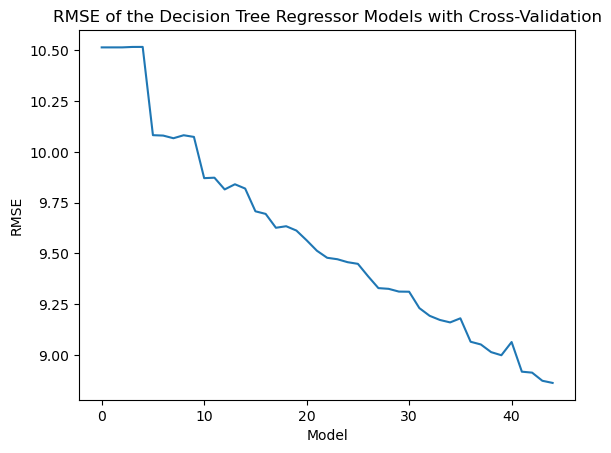

In [134]:
# plot all the RMSE values of the models to see the difference in the cross-validated RMSE
plt.plot(cvModel.avgMetrics)
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE of the Decision Tree Regressor Models with Cross-Validation')
plt.show()

In [138]:
# print the feature importances
feature_importances = cvModel.bestModel.featureImportances
feature_importances_df = pd.DataFrame(list(zip(stocks_brent_gold_df_spark.columns[2:], feature_importances)),
                                      columns=["Feature", "Importance"])

# sort the DataFrame by feature importance in descending order
feature_importances_df = feature_importances_df.sort_values("Importance", ascending=False)

# display the feature importances
print(feature_importances_df)

         Feature  Importance
0  trading_name     0.445838
5            low    0.286247
3           open    0.102056
4           high    0.079378
1         Sector    0.049453
2           Date    0.037028


In [104]:
# print the hyperparameters of the best model
# The hyperparameters of the best model can provide insights into the configuration that yielded the best performance.
# Understanding the hyperparameters can help you tune future models and optimize their performance.
# The hyperparameters of the best model can guide further experimentation and refinement of the model.
print(cvModel.bestModel._java_obj.getMaxDepth())
print(cvModel.bestModel._java_obj.getMaxBins())

10
100


+-------------------+-----------+-----------------+
|               Date|Stock_Price|       prediction|
+-------------------+-----------+-----------------+
|2020-01-23 00:00:00|       90.9|11.66245487364621|
|2020-01-22 00:00:00|       91.8|11.66245487364621|
|2020-01-21 00:00:00|       92.0|11.66245487364621|
|2020-01-20 00:00:00|       92.9|11.66245487364621|
|2020-01-16 00:00:00|       92.8|11.66245487364621|
|2020-01-15 00:00:00|       92.4|11.66245487364621|
|2020-01-14 00:00:00|       93.2|8.193675889328063|
|2020-01-13 00:00:00|       92.7|8.193675889328063|
|2020-01-09 00:00:00|       92.0|8.193675889328063|
|2020-01-08 00:00:00|       90.5|11.66245487364621|
|2020-01-07 00:00:00|       91.0|8.193675889328063|
|2020-01-06 00:00:00|       91.9|11.66245487364621|
|2020-01-02 00:00:00|       93.4|8.193675889328063|
|2020-01-01 00:00:00|       93.1|8.193675889328063|
|2019-12-31 00:00:00|       93.9|11.66245487364621|
|2019-12-30 00:00:00|       93.7|3.005581395348837|
|2019-12-26 

24/05/05 22:45:51 WARN TaskSetManager: Stage 5317 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:45:51 WARN TaskSetManager: Stage 5318 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


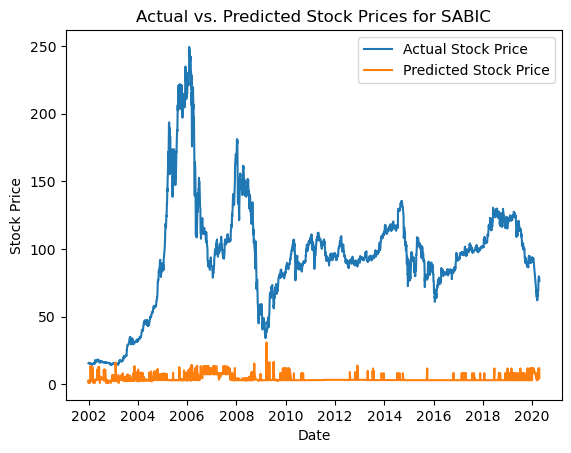

In [139]:
# create a table for SABIC actual and predicted stock prices

# get the predictions
predictions = cvModel.transform(stocks_brent_gold_df_spark)

# select the relevant columns for SABIC stock prices
sabic_predictions = predictions.select("Date", "Stock_Price", "prediction").filter(predictions.name == "Saudi Basic Industries Corp.")

# display the actual and predicted stock prices for SABIC
sabic_predictions.show()

# plot the actual and predicted stock prices for SABIC
sns.lineplot(data=sabic_predictions.toPandas(), x="Date", y="Stock_Price", label="Actual Stock Price")
sns.lineplot(data=sabic_predictions.toPandas(), x="Date", y="prediction", label="Predicted Stock Price")
plt.title("Actual vs. Predicted Stock Prices for SABIC")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

- we notice that the DecisionTreeRegressor model is not performing well; this can be due to the fact that the cross-validation is not respecting the time in the time-series data

- we can try to use the test:train split method instead of cross-validation to verify if it yeilds better results

In [140]:
# split the data into training and testing
# 80% of the data is used for training and 20% for testing
(trainingData, testData) = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])

# Define the DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol="StockIndex")

# Train the model on the training data
model = dt.fit(trainingData)

# Make predictions on the test data
predictions = model.transform(testData)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="StockIndex", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

24/05/05 22:46:07 WARN TaskSetManager: Stage 5320 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:46:07 WARN TaskSetManager: Stage 5321 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:46:08 WARN TaskSetManager: Stage 5323 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:46:08 WARN TaskSetManager: Stage 5325 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:46:08 WARN TaskSetManager: Stage 5327 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:46:08 WARN TaskSetManager: Stage 5329 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:46:08 WARN TaskSetManager: Stage 5331 contains a task of very large size (1102 KiB). The maximum recommended task size is 10

Root Mean Squared Error (RMSE): 9.664520426619442


In [107]:
# we do non-random split to respect the time in the time-series data
# we split the data by date
# the training data is before 2018 and the testing data is after 2018
trainingData2 = stocks_brent_gold_df_spark.filter(stocks_brent_gold_df_spark.Date < '2018-01-01')
testData2 = stocks_brent_gold_df_spark.filter(stocks_brent_gold_df_spark.Date >= '2018-01-01')

# Define the DecisionTreeRegressor
dt2 = DecisionTreeRegressor(featuresCol="features", labelCol="StockIndex")

# Train the model on the training data
model2 = dt.fit(trainingData2)

# Make predictions on the test data
predictions2 = model2.transform(testData2)

# Evaluate the model
evaluator2 = RegressionEvaluator(labelCol="StockIndex", predictionCol="prediction", metricName="rmse")
rmse2 = evaluator2.evaluate(predictions2)
print("Root Mean Squared Error (RMSE):", rmse2)

24/04/30 14:08:21 WARN TaskSetManager: Stage 4274 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:08:21 WARN TaskSetManager: Stage 4275 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:08:22 WARN TaskSetManager: Stage 4276 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:08:22 WARN TaskSetManager: Stage 4278 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:08:22 WARN TaskSetManager: Stage 4280 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:08:22 WARN TaskSetManager: Stage 4282 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/04/30 14:08:22 WARN TaskSetManager: Stage 4284 contains a task of very large size (1102 KiB). The maximum recommended task size is 10

Root Mean Squared Error (RMSE): 12.913640337534394


24/05/05 22:46:59 WARN TaskSetManager: Stage 5335 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


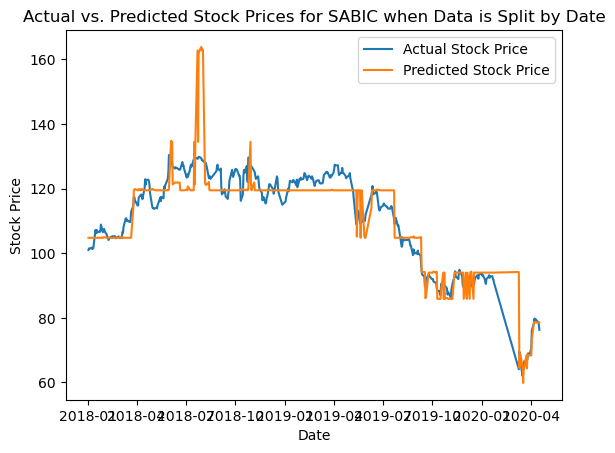

In [141]:
# plot the actual and predicted stock prices for SABIC when the data is split by date
sabic_predictions2 = predictions2.select("Date", "Stock_Price", "prediction").filter(predictions2.name == "Saudi Basic Industries Corp.")
sns.lineplot(data=sabic_predictions2.toPandas(), x="Date", y="Stock_Price", label="Actual Stock Price")
sns.lineplot(data=sabic_predictions2.toPandas(), x="Date", y="prediction", label="Predicted Stock Price")
plt.title("Actual vs. Predicted Stock Prices for SABIC when Data is Split by Date")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

- from above, we see Regression isn't yeilding good results

# 2.3 Model Selection: GBTRgressor

Purpose: To improve accuracy in predicting stock prices using an ensemble of decision trees.

Features: Includes complex features like lagged stock prices to account for past performance.

Methodology: Combines multiple weak predictive models to build a stronger model, enhancing prediction accuracy through boosting techniques.

In [143]:
# before we try different models, we need to preprocess the data again
stocks_brent_gold_df = preprocess_data(stocks_df, brent_df, gold_df)
stocks_brent_gold_df_spark = spark.createDataFrame(stocks_brent_gold_df)

In [144]:
# in the spark dataframe, create lagged features for the stock price with window size of 5 considering the date and unique stock symbol
windowSpec = Window.partitionBy("name").orderBy("Date")
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Stock_Price_Lag1", F.lag("Stock_Price", 1).over(windowSpec))
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Stock_Price_Lag2", F.lag("Stock_Price", 2).over(windowSpec))
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Stock_Price_Lag3", F.lag("Stock_Price", 3).over(windowSpec))
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Stock_Price_Lag4", F.lag("Stock_Price", 4).over(windowSpec))
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Stock_Price_Lag5", F.lag("Stock_Price", 5).over(windowSpec))


In [145]:
stocks_brent_gold_df_spark.show()

+------+---------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+----------------+----------------+----------------+----------------+----------------+
|symbol|           name|trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|Stock_Price_Lag1|Stock_Price_Lag2|Stock_Price_Lag3|Stock_Price_Lag4|Stock_Price_Lag5|
+------+---------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+----------------+----------------+----------------+----------------+----------------+
|  3001|Hail Cement Co.|          HCC|Materials|2011-10-17 00:00:00| 12.6| 12.6| 12.3|       12.5|  -0.1|      -0.79|     9542486.0| 1.193622578E8|   11053.0|     112.92|    1675.5|            NULL| 

24/05/05 22:47:48 WARN TaskSetManager: Stage 5340 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [146]:
# identify the missing values in the dataframe
stocks_brent_gold_df_spark.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in stocks_brent_gold_df_spark.columns]).show()

24/05/05 22:47:50 WARN TaskSetManager: Stage 5343 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


+------+----+-------------+------+----+----+----+---+-----------+------+-----------+--------------+------------+----------+-----------+----------+----------------+----------------+----------------+----------------+----------------+
|symbol|name|trading_name |Sector|Date|open|high|low|Stock_Price|change|perc_Change|volume_traded |value_traded|no_trades |Brent_Price|Gold_Price|Stock_Price_Lag1|Stock_Price_Lag2|Stock_Price_Lag3|Stock_Price_Lag4|Stock_Price_Lag5|
+------+----+-------------+------+----+----+----+---+-----------+------+-----------+--------------+------------+----------+-----------+----------+----------------+----------------+----------------+----------------+----------------+
|     0|   0|            0|     0|   0|   0|   0|  0|          0|     0|          0|             0|           0|         0|          0|         0|              47|              94|             141|             188|             235|
+------+----+-------------+------+----+----+----+---+-----------+------+

In [147]:
# view total number of rows in the dataframe
stocks_brent_gold_df_spark.count()

24/05/05 22:47:52 WARN TaskSetManager: Stage 5349 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


107722

In [148]:
# drop the rows with missing values
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.dropna()

In [149]:
stocks_brent_gold_df_spark.show()

+------+---------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+----------------+----------------+----------------+----------------+----------------+
|symbol|           name|trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|Stock_Price_Lag1|Stock_Price_Lag2|Stock_Price_Lag3|Stock_Price_Lag4|Stock_Price_Lag5|
+------+---------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+----------------+----------------+----------------+----------------+----------------+
|  3001|Hail Cement Co.|          HCC|Materials|2011-10-26 00:00:00| 12.8| 13.0| 12.6|       12.7|  -0.1|      -0.78|     6826345.0| 8.711935275E7|    3146.0|     110.43|    1722.7|            12.8| 

24/05/05 22:47:55 WARN TaskSetManager: Stage 5352 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [150]:
# identify the missing values in the dataframe
stocks_brent_gold_df_spark.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in stocks_brent_gold_df_spark.columns]).show()

24/05/05 22:47:57 WARN TaskSetManager: Stage 5355 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


+------+----+-------------+------+----+----+----+---+-----------+------+-----------+--------------+------------+----------+-----------+----------+----------------+----------------+----------------+----------------+----------------+
|symbol|name|trading_name |Sector|Date|open|high|low|Stock_Price|change|perc_Change|volume_traded |value_traded|no_trades |Brent_Price|Gold_Price|Stock_Price_Lag1|Stock_Price_Lag2|Stock_Price_Lag3|Stock_Price_Lag4|Stock_Price_Lag5|
+------+----+-------------+------+----+----+----+---+-----------+------+-----------+--------------+------------+----------+-----------+----------+----------------+----------------+----------------+----------------+----------------+
|     0|   0|            0|     0|   0|   0|   0|  0|          0|     0|          0|             0|           0|         0|          0|         0|               0|               0|               0|               0|               0|
+------+----+-------------+------+----+----+----+---+-----------+------+

In [151]:
# view total number of rows in the dataframe
stocks_brent_gold_df_spark.count()

24/05/05 22:47:59 WARN TaskSetManager: Stage 5361 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


107487

In [152]:
# duplicate the label column to use it as a feature
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("label", stocks_brent_gold_df_spark["Stock_Price"])

In [153]:
stocks_brent_gold_df_spark.show()

+------+---------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+----------------+----------------+----------------+----------------+----------------+-----+
|symbol|           name|trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|Stock_Price_Lag1|Stock_Price_Lag2|Stock_Price_Lag3|Stock_Price_Lag4|Stock_Price_Lag5|label|
+------+---------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+----------------+----------------+----------------+----------------+----------------+-----+
|  3001|Hail Cement Co.|          HCC|Materials|2011-10-26 00:00:00| 12.8| 13.0| 12.6|       12.7|  -0.1|      -0.78|     6826345.0| 8.711935275E7|    3146.0|     110.43|    1722.7|

24/05/05 22:48:01 WARN TaskSetManager: Stage 5367 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [154]:
# print the dataframe to verify the columns are dropped
stocks_brent_gold_df_spark.show()

+------+---------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+----------------+----------------+----------------+----------------+----------------+-----+
|symbol|           name|trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|Stock_Price_Lag1|Stock_Price_Lag2|Stock_Price_Lag3|Stock_Price_Lag4|Stock_Price_Lag5|label|
+------+---------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+----------------+----------------+----------------+----------------+----------------+-----+
|  3001|Hail Cement Co.|          HCC|Materials|2011-10-26 00:00:00| 12.8| 13.0| 12.6|       12.7|  -0.1|      -0.78|     6826345.0| 8.711935275E7|    3146.0|     110.43|    1722.7|

24/05/05 22:48:03 WARN TaskSetManager: Stage 5370 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


In [155]:
# print features of the dataframe
stocks_brent_gold_df_spark.printSchema()

root
 |-- symbol: long (nullable = true)
 |-- name: string (nullable = true)
 |-- trading_name : string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- Stock_Price: double (nullable = true)
 |-- change: double (nullable = true)
 |-- perc_Change: double (nullable = true)
 |-- volume_traded : double (nullable = true)
 |-- value_traded: double (nullable = true)
 |-- no_trades : double (nullable = true)
 |-- Brent_Price: double (nullable = true)
 |-- Gold_Price: double (nullable = true)
 |-- Stock_Price_Lag1: double (nullable = true)
 |-- Stock_Price_Lag2: double (nullable = true)
 |-- Stock_Price_Lag3: double (nullable = true)
 |-- Stock_Price_Lag4: double (nullable = true)
 |-- Stock_Price_Lag5: double (nullable = true)
 |-- label: double (nullable = true)



In [156]:
# create feature vector
vectorAssembler = VectorAssembler(inputCols=["volume_traded ", "value_traded", "no_trades ", "Stock_Price_Lag1", "Stock_Price_Lag2", "Stock_Price_Lag3", "Stock_Price_Lag4", "Stock_Price_Lag5", "Brent_Price", "Gold_Price"], outputCol="features")
stocks_brent_gold_df_spark = vectorAssembler.transform(stocks_brent_gold_df_spark)


In [157]:
# implement a model that predicts the stock price of SABIC
from pyspark.ml.regression import GBTRegressor
# split the data into training and testing
# 80% of the data is used for training and 20% for testing
(trainingData, testData) = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])

# Define the GBTRegressor
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxBins=47)

# Train the model on the training data
model = gbt.fit(trainingData)

# Make predictions on the test data
predictions = model.transform(testData)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

24/05/05 22:48:22 WARN TaskSetManager: Stage 5373 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:48:22 WARN TaskSetManager: Stage 5374 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:48:25 WARN TaskSetManager: Stage 5682 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


Root Mean Squared Error (RMSE): 4.608167536653795


In [160]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
print("Mean Squared Error (MSE):", mse)

24/05/05 22:48:51 WARN TaskSetManager: Stage 5691 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


Mean Squared Error (MSE): 21.235208045869904


In [161]:
# print predictions for SABIC and the actual stock price
sabic_predictions = predictions.select("Date", "Stock_Price", "prediction").filter(predictions.name == "Saudi Basic Industries Corp.")
sabic_predictions.show()


24/05/05 22:49:03 WARN TaskSetManager: Stage 5694 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


+-------------------+-----------+------------------+
|               Date|Stock_Price|        prediction|
+-------------------+-----------+------------------+
|2002-01-10 00:00:00|      15.75|15.498952805530871|
|2002-01-23 00:00:00|      15.25|15.498952805530871|
|2002-01-24 00:00:00|      15.25|15.498952805530871|
|2002-02-27 00:00:00|       14.5|14.778388296268213|
|2002-03-14 00:00:00|       15.0|15.498952805530871|
|2002-03-20 00:00:00|      15.25|15.498952805530871|
|2002-03-25 00:00:00|      15.25|15.498952805530871|
|2002-04-10 00:00:00|       16.5|16.246877747293524|
|2002-05-02 00:00:00|       18.0|18.562263546986394|
|2002-05-14 00:00:00|       18.0| 18.45620250949473|
|2002-05-22 00:00:00|      18.25|18.747007003544613|
|2002-05-29 00:00:00|       18.0|18.509246423889817|
|2002-06-05 00:00:00|       17.5|18.381292973368346|
|2002-07-03 00:00:00|       17.0|16.246877747293524|
|2002-07-08 00:00:00|      17.25| 16.19383383289843|
|2002-07-09 00:00:00|      17.25|16.1189242967

24/05/05 22:49:06 WARN TaskSetManager: Stage 5697 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


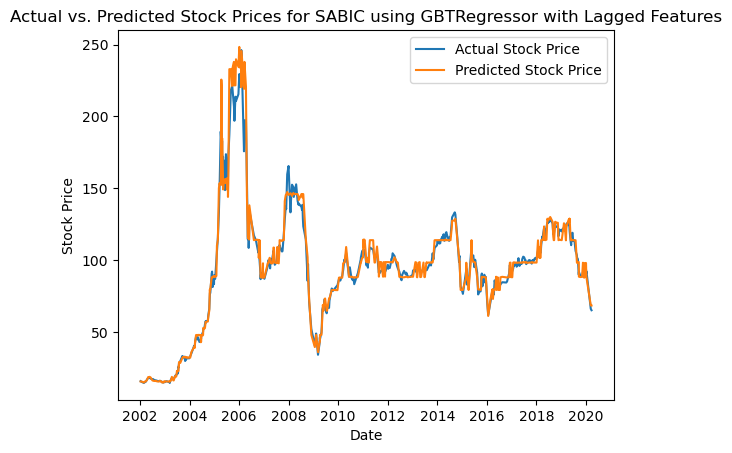

In [162]:
# plot the actual and predicted stock prices for SABIC
sns.lineplot(data=sabic_predictions.toPandas(), x="Date", y="Stock_Price", label="Actual Stock Price")
sns.lineplot(data=sabic_predictions.toPandas(), x="Date", y="prediction", label="Predicted Stock Price")
plt.title("Actual vs. Predicted Stock Prices for SABIC using GBTRegressor with Lagged Features")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

24/05/05 22:49:49 WARN TaskSetManager: Stage 6022 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:49:50 WARN TaskSetManager: Stage 6025 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


+-------------------+-----------+-----------------+
|               Date|Stock_Price|       prediction|
+-------------------+-----------+-----------------+
|2008-02-06 00:00:00|      49.25|52.86550094938216|
|2008-02-11 00:00:00|       46.0|47.96753734513019|
|2008-02-12 00:00:00|       48.0|47.96753734513019|
|2008-02-13 00:00:00|      46.75|47.96753734513019|
|2008-02-19 00:00:00|       48.0|47.96753734513019|
|2008-02-20 00:00:00|      48.75|47.96753734513019|
|2008-02-25 00:00:00|       49.5|47.96753734513019|
|2008-02-26 00:00:00|       50.0|47.96753734513019|
|2008-02-27 00:00:00|      51.25|52.86550094938216|
|2008-03-03 00:00:00|       48.5|52.80694229318995|
|2008-03-04 00:00:00|      49.75|47.96753734513019|
|2008-03-05 00:00:00|      49.25|52.80694229318995|
|2008-03-10 00:00:00|      47.75|47.97547232233161|
|2008-03-11 00:00:00|      49.25|47.97547232233161|
|2008-03-12 00:00:00|       49.0|47.96753734513019|
|2008-03-17 00:00:00|       47.5|47.97547232233161|
|2008-03-18 

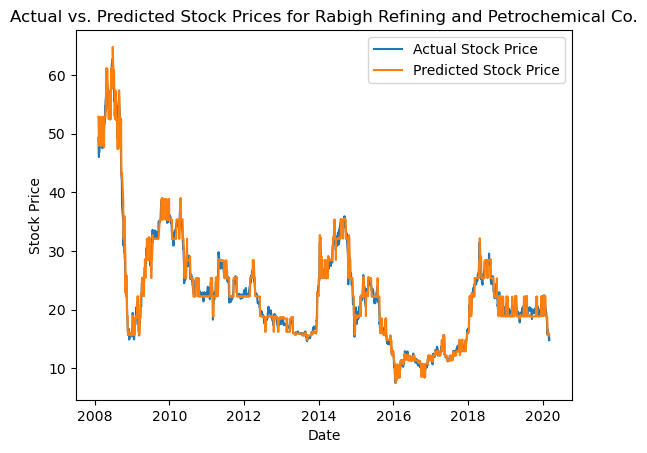

In [164]:
# show prediction vs actual stock price for Rabigh Refining and Petrochemical Co.
# get the predictions
predictions = model.transform(stocks_brent_gold_df_spark)

# select the relevant columns for Rabigh Refining and Petrochemical Co. stock prices
rabigh_predictions = predictions.select("Date", "Stock_Price", "prediction").filter(predictions.name == "Rabigh Refining and Petrochemical Co.")

# display the actual and predicted stock prices for Rabigh Refining and Petrochemical Co.
rabigh_predictions.show()

# plot the actual and predicted stock prices for Rabigh Refining and Petrochemical Co.
sns.lineplot(data=rabigh_predictions.toPandas(), x="Date", y="Stock_Price", label="Actual Stock Price")
sns.lineplot(data=rabigh_predictions.toPandas(), x="Date", y="prediction", label="Predicted Stock Price")
plt.title("Actual vs. Predicted Stock Prices for Rabigh Refining and Petrochemical Co.")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [168]:
# print feature importances
feature_importances = model.featureImportances
feature_importances_df = pd.DataFrame(list(zip(["volume_traded ", "value_traded", "no_trades ", "Stock_Price_Lag1", "Stock_Price_Lag2", "Stock_Price_Lag3", "Stock_Price_Lag4", "Stock_Price_Lag5", "Brent_Price", "Gold_Price"], feature_importances)),
                                      columns=["Feature", "Importance"])
feature_importances_df = feature_importances_df.sort_values("Importance", ascending=False)
print(feature_importances_df)

            Feature  Importance
3  Stock_Price_Lag1    0.795934
0    volume_traded     0.079608
1      value_traded    0.076506
9        Gold_Price    0.016479
8       Brent_Price    0.011008
2        no_trades     0.009510
7  Stock_Price_Lag5    0.007315
4  Stock_Price_Lag2    0.001759
5  Stock_Price_Lag3    0.001138
6  Stock_Price_Lag4    0.000743


# 2.4 Model Selection: SGD

Purpose: To optimize regression models efficiently for large datasets, suitable for high-dimensional spaces.

Features: Handles diverse features including continuous variables and time-series derivatives like lagged stock prices.

Methodology: Employs an iterative gradient descent algorithm to update parameters incrementally, optimizing the loss function effectively for scalability and speed.

In [169]:
# before we try different models, we need to preprocess the data again
stocks_brent_gold_df = preprocess_data(stocks_df, brent_df, gold_df)
stocks_brent_gold_df_spark = spark.createDataFrame(stocks_brent_gold_df)

In [170]:
# duplicate the label column to use it as a feature
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("label", stocks_brent_gold_df_spark["Stock_Price"])

In [171]:
# create lagged features for the stock price with window size of 5 considering the date and unique stock symbol
windowSpec = Window.partitionBy("name").orderBy("Date")
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Stock_Price_Lag1", F.lag("Stock_Price", 1).over(windowSpec))
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Stock_Price_Lag2", F.lag("Stock_Price", 2).over(windowSpec))
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Stock_Price_Lag3", F.lag("Stock_Price", 3).over(windowSpec))
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Stock_Price_Lag4", F.lag("Stock_Price", 4).over(windowSpec))
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.withColumn("Stock_Price_Lag5", F.lag("Stock_Price", 5).over(windowSpec))

In [172]:
stocks_brent_gold_df_spark.show()

24/05/05 22:51:48 WARN TaskSetManager: Stage 6030 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


+------+---------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----+----------------+----------------+----------------+----------------+----------------+
|symbol|           name|trading_name |   Sector|               Date| open| high|  low|Stock_Price|change|perc_Change|volume_traded |  value_traded|no_trades |Brent_Price|Gold_Price|label|Stock_Price_Lag1|Stock_Price_Lag2|Stock_Price_Lag3|Stock_Price_Lag4|Stock_Price_Lag5|
+------+---------------+-------------+---------+-------------------+-----+-----+-----+-----------+------+-----------+--------------+--------------+----------+-----------+----------+-----+----------------+----------------+----------------+----------------+----------------+
|  3001|Hail Cement Co.|          HCC|Materials|2011-10-17 00:00:00| 12.6| 12.6| 12.3|       12.5|  -0.1|      -0.79|     9542486.0| 1.193622578E8|   11053.0|     112.92|    1675.5|

In [173]:
# drop the rows with missing values
stocks_brent_gold_df_spark = stocks_brent_gold_df_spark.dropna()

In [174]:
# create feature vector
vectorAssembler = VectorAssembler(inputCols=["volume_traded ", "value_traded", "no_trades ", "Stock_Price_Lag1", "Stock_Price_Lag2", "Stock_Price_Lag3", "Stock_Price_Lag4", "Stock_Price_Lag5", "Brent_Price", "Gold_Price"], outputCol="features")
stocks_brent_gold_df_spark = vectorAssembler.transform(stocks_brent_gold_df_spark)

In [175]:
# view rows with missing values
stocks_brent_gold_df_spark.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in stocks_brent_gold_df_spark.columns]).show()

24/05/05 22:51:54 WARN TaskSetManager: Stage 6033 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


+------+----+-------------+------+----+----+----+---+-----------+------+-----------+--------------+------------+----------+-----------+----------+-----+----------------+----------------+----------------+----------------+----------------+--------+
|symbol|name|trading_name |Sector|Date|open|high|low|Stock_Price|change|perc_Change|volume_traded |value_traded|no_trades |Brent_Price|Gold_Price|label|Stock_Price_Lag1|Stock_Price_Lag2|Stock_Price_Lag3|Stock_Price_Lag4|Stock_Price_Lag5|features|
+------+----+-------------+------+----+----+----+---+-----------+------+-----------+--------------+------------+----------+-----------+----------+-----+----------------+----------------+----------------+----------------+----------------+--------+
|     0|   0|            0|     0|   0|   0|   0|  0|          0|     0|          0|             0|           0|         0|          0|         0|    0|               0|               0|               0|               0|               0|       0|
+------+----

In [176]:
# implement a Stochastic Gradient Descent - SGD
# split the data into training and testing
# 80% of the data is used for training and 20% for testing
(trainingData, testData) = stocks_brent_gold_df_spark.randomSplit([0.8, 0.2])

# Define the Stochastic Gradient Descent - SGD
from pyspark.ml.regression import GeneralizedLinearRegression
sgd = GeneralizedLinearRegression(featuresCol="features", labelCol="label")

# Train the model on the training data
model = sgd.fit(trainingData)

# Make predictions on the test data
predictions = model.transform(testData)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

24/05/05 22:51:56 WARN TaskSetManager: Stage 6039 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:51:56 WARN TaskSetManager: Stage 6040 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.
24/05/05 22:51:56 WARN Instrumentation: [6eec1408] regParam is zero, which might cause numerical instability and overfitting.
24/05/05 22:51:56 WARN TaskSetManager: Stage 6044 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


Root Mean Squared Error (RMSE): 2.0725041926781245


In [177]:
# print MSE
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse") 
mse = evaluator.evaluate(predictions)
print("Mean Squared Error (MSE):", mse)

24/05/05 22:52:17 WARN TaskSetManager: Stage 6048 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


Mean Squared Error (MSE): 4.295273628668405


In [178]:
# print the accuracy of the model
# The accuracy of the model is a measure of how well the model is able to predict the stock price of SABIC.

# The accuracy of the model is calculated by comparing the predicted stock price to the actual stock price.


# get the predictions
predictions = model.transform(testData)

# select the relevant columns for SABIC stock prices
sabic_predictions = predictions.select("Date", "Stock_Price", "prediction").filter(predictions.name == "Saudi Basic Industries Corp.")

# display the actual and predicted stock prices for SABIC
sabic_predictions.show(100)



24/05/05 22:52:26 WARN TaskSetManager: Stage 6052 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


+-------------------+-----------+------------------+
|               Date|Stock_Price|        prediction|
+-------------------+-----------+------------------+
|2002-01-10 00:00:00|      15.75|15.811783079532493|
|2002-01-17 00:00:00|      15.75|15.559669287802253|
|2002-01-30 00:00:00|       15.5|15.576618603504977|
|2002-02-05 00:00:00|       15.0|15.293301513305336|
|2002-02-07 00:00:00|       15.0| 15.04688658119703|
|2002-02-12 00:00:00|       15.0|15.068641456146867|
|2002-02-19 00:00:00|       14.5| 14.53704854050009|
|2002-02-27 00:00:00|       14.5| 14.56794928090209|
|2002-03-04 00:00:00|       14.5| 14.57093232925596|
|2002-03-11 00:00:00|       15.5|15.089104212141255|
|2002-03-14 00:00:00|       15.0|15.076752718562355|
|2002-04-01 00:00:00|       15.0|15.586492278603318|
|2002-04-08 00:00:00|      17.75|15.539592700425311|
|2002-04-18 00:00:00|      16.25|  16.5505658792712|
|2002-05-20 00:00:00|      18.25| 18.01518787236591|
|2002-05-29 00:00:00|       18.0| 18.045892039

24/05/05 22:52:28 WARN TaskSetManager: Stage 6055 contains a task of very large size (1102 KiB). The maximum recommended task size is 1000 KiB.


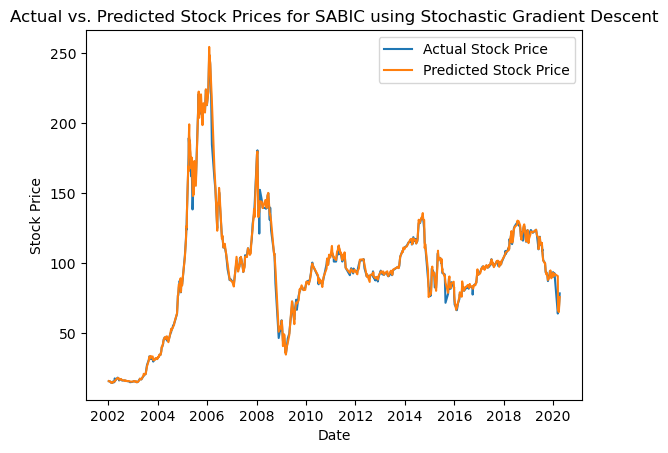

In [179]:
# plot the actual and predicted stock prices for SABIC
sns.lineplot(data=sabic_predictions.toPandas(), x="Date", y="Stock_Price", label="Actual Stock Price")
sns.lineplot(data=sabic_predictions.toPandas(), x="Date", y="prediction", label="Predicted Stock Price")
plt.title("Actual vs. Predicted Stock Prices for SABIC using Stochastic Gradient Descent")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [182]:
# Stop the Spark session
spark.stop()